In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind

In [4]:
%matplotlib widget

# Load subject

In [5]:
data_loc = r"P:\mouse771427\THstim_d1_2025-01-22_10-36-51\experiment1\recording1"

In [6]:
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print('{} - {}'.format(exp.mouse, exp_tag))

Experiment type: electrical stimulation
771427 - THstim_d1


Load stim log

In [7]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

Load the Pupileye .csv file

In [8]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilD)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilD[:k]
    sm_pupil[-k-1:] = pupilD[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)

else:
    print('No local Pupileye*.csv file. Check server.')

In [9]:
print('Pupil NaN values: {:d}/{:d} frames'.format(np.sum(np.isnan(pupil)), len(pupil)))

Pupil NaN values: 37/159862 frames


Text(0.5, 1.0, 'Pupil size over whole recording')

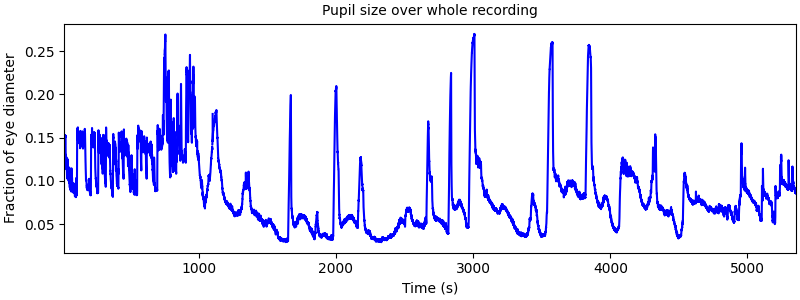

In [10]:
fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)

ax.plot(pupilts, pupil, 'b', label='pupil')
ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fraction of eye diameter')
ax.set_title('Pupil size over whole recording')

### Look at events

In [12]:
stim_log.head()

,event_type,event_ID,stim_type,parameter,onset,offset,duration,sweep
0,freq50Hz,0,biphasic,10,1507.18929,1507.18969,0.0004,0
1,freq50Hz,0,biphasic,10,1507.20929,1507.20969,0.0004,0
2,freq50Hz,0,biphasic,10,1507.22929,1507.22969,0.0004,0
3,freq50Hz,0,biphasic,10,1507.24929,1507.24969,0.0004,0
4,freq50Hz,0,biphasic,10,1507.26929,1507.26969,0.0004,0


### Plot histogram of pupil and eye diameter values

Text(0.5, 0, 'Pixels')

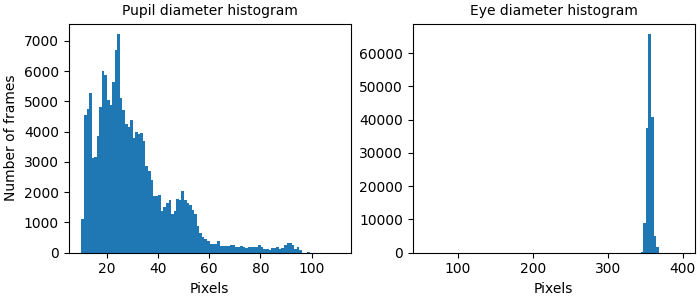

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), constrained_layout=True)

axs[0].hist(pupilD, bins=100)
axs[0].set_title('Pupil diameter histogram')
axs[0].set_ylabel('Number of frames')
axs[0].set_xlabel('Pixels')

axs[1].hist(eyeD, bins=100)
axs[1].set_title('Eye diameter histogram')
axs[1].set_xlabel('Pixels')

The eye diameter values fall between 320-360 pixels, typically.
<br> The pupil diameter values fall between ~10-120 pixels, typically. But it varies much more than the eye.

### Plot raw pupil and eye diameters over time

### Get the normalized pupil diameter

In [13]:
## pupil diameter / mean eye diameter
norm_pupil = pupilD / np.mean(eyeD)

### Smooth the pupil diameter to remove outliers

In [14]:
## smooth pupil diameter, then normalize ##
sm_pupilD = np.zeros_like(pupilD)
k = 5 # filter window is actually k*2+1
for i in range(k, len(pupilD)-k-1):
    sm_pupilD[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
sm_pupilD[:k] = pupilD[:k]
sm_pupilD[-k-1:] = pupilD[-k-1:]
norm_smpupil = sm_pupilD / np.mean(eyeD)

Text(0.5, 1.0, 'Normalized pupil over whole recording')

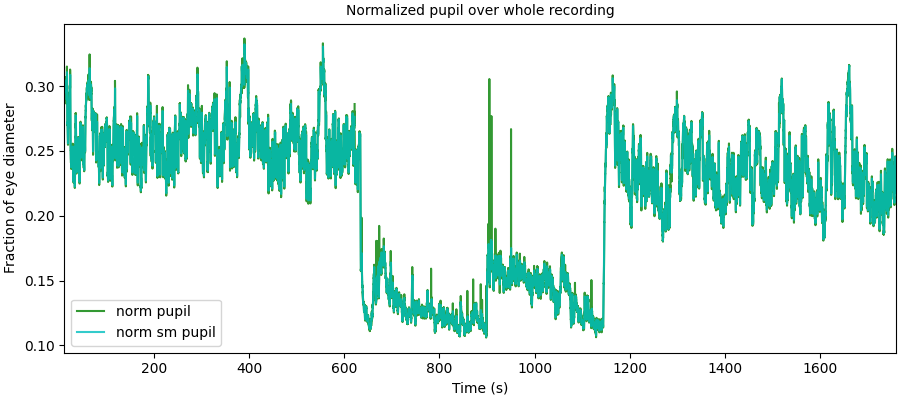

In [15]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

ax.plot(pupilts, norm_pupil, 'g', label='norm pupil', alpha=0.8)
ax.plot(pupilts, norm_smpupil, 'c', label='norm sm pupil', alpha=0.8)

ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fraction of eye diameter')
ax.legend()
ax.set_title('Normalized pupil over whole recording')

### Plot the pupil center over time

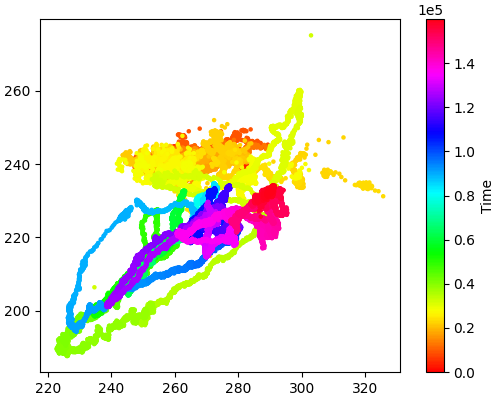

In [11]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

tpcol = ax.scatter(pupildf.X_Position.values, pupildf.Y_Position.values, c=range(len(pupildf)), s=5, cmap=plt.cm.get_cmap('hsv'))
fig.colorbar(tpcol, ax=ax, label='Time')